In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
from netCDF4 import num2date
from mpl_toolkits.basemap import Basemap
import mpl_toolkits.basemap as basemap
import getpass

# Humboldt

## Datos Reanalisis

In [168]:
t_ini=np.datetime64('1993-01-01T12:00:00.000000000')
t_fin= np.datetime64('2017-12-31T12:00:00.000000000')
print(t_ini,t_fin)

1993-01-01T12:00:00.000000000 2017-12-31T12:00:00.000000000


In [169]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_PHY_SSH/Humboldt/Data_anual/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
R=xr.open_dataset('GLOBAL_REANALYSIS_PHY_SSH.nc')
R=R.where((R.time >=t_ini)&(R.time <= t_fin),drop=True)
R2= R.groupby('time.month').mean()
R2

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_PHY_SSH/Humboldt/Data_anual


<xarray.Dataset>
Dimensions:  (month: 12, lat: 121, lon: 61)
Coordinates:
  * lon      (lon) float32 275.0 275.2 275.5 275.8 ... 289.2 289.5 289.8 290.0
  * lat      (lat) float32 -45.0 -44.75 -44.5 -44.25 ... -15.5 -15.25 -15.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    SSH      (month, lat, lon) float32 -0.04357 -0.04479 -0.04506 ... nan nan

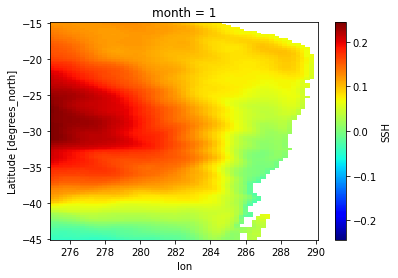

In [170]:
R2.sel(month=1).SSH.plot(cmap='jet')

## Datos Misiones satelitales

Datos de misiones satelitales DUACS: https://resources.marine.copernicus.eu/product-detail/SEALEVEL_GLO_PHY_L4_MY_008_047/INFORMATION

In [171]:
%ls '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/Datos_SSH_Satelite/'

GLOBAL_SSH_Benguela.nc    GLOBAL_SSH_Canarias.nc
GLOBAL_SSH_California.nc  GLOBAL_SSH_Humboldt.nc


In [172]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/Datos_SSH_Satelite/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
S=xr.open_dataset('GLOBAL_SSH_Humboldt.nc')
S 

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/Datos_SSH_Satelite


<xarray.Dataset>
Dimensions:         (month: 12, latitude: 60, longitude: 30, nv: 2)
Coordinates:
  * latitude        (latitude) float32 -44.75 -44.25 -43.75 ... -15.75 -15.25
  * longitude       (longitude) float32 -84.75 -84.25 -83.75 ... -70.75 -70.25
  * month           (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    SSH             (month, latitude, longitude) float32 ...
    SSHIBC          (month, latitude, longitude) float32 ...
    SSHNOIBC        (month, latitude, longitude) float32 ...
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...

## Interpolacion Reanalisis a Satelite

(60, 30)


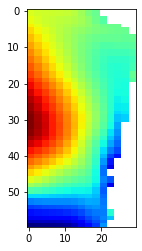

In [173]:
plt.imshow(np.flipud(S.SSH.sel(month=1).values),cmap='jet')
print(np.flipud(S.SSH.sel(month=1).values).shape)

(60, 30)


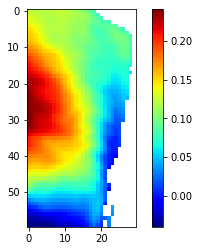

In [174]:
# Ejemplo para un mes
x= S.longitude.values
y= S.latitude.values
X_t, Y_t= np.meshgrid(x,y)
SSH_out=basemap.interp(datain=R2.sel(month=1).SSH.values, xin=R2.lon.values-360, yin=R2.lat.values, 
                            xout=X_t, yout=Y_t, order=1, masked= True)
print(SSH_out.shape)
plt.imshow(np.flipud(SSH_out),cmap='jet')
plt.colorbar()
plt.show()

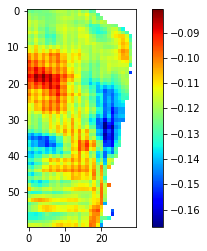

In [175]:
plt.imshow(np.flipud(SSH_out)-np.flipud(S.SSH.sel(month=1).values),cmap='jet')
plt.colorbar()

## Grafico de sesgo 

In [176]:
x1= S.longitude.values
y1=S.latitude.values;y1=y1[::-1];y1= np.array(y1);

In [177]:
!pip install cmocean
import cmocean

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


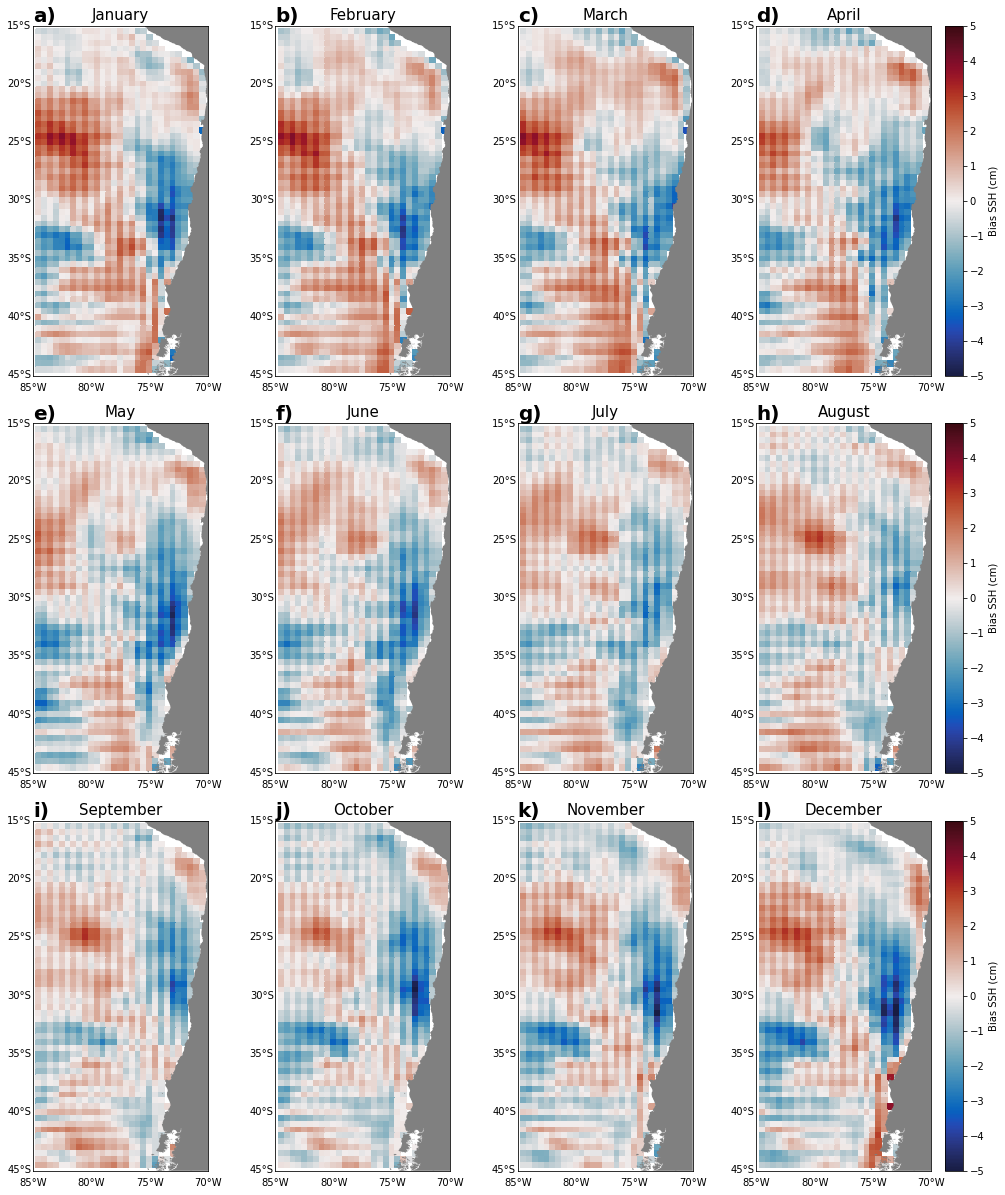

In [178]:
import string
ticks= np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5]) #labels para el colorbar
x1= S.longitude.values;y1=S.latitude.values;y1=y1[::-1];y1= np.array(y1);
w=0.23;h=0.22
meses=['January','February','March','April','May','June','July','August','September','October','November','December']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.4,w,h],[0.2,0.4,w,h],[0.4,0.4,w,h],[0.6,0.4,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(0.,1.01,string.ascii_lowercase[j]+')',fontsize=20, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=15)
  m=Basemap(projection='cyl',llcrnrlon=-85,llcrnrlat=-45,urcrnrlon=-70,urcrnrlat=-15, resolution ='h')
  x, y = m(x1, y1)
  # Interpolacion
  SSH_out=basemap.interp(datain=R2.sel(month=j+1).SSH.values, xin=R2.lon.values-360, yin=R2.lat.values, 
                            xout=X_t, yout=Y_t, order=1, masked= True)
  # Variable de interes sesgo
  z=(np.flipud(SSH_out)+0.12)-np.flipud(S.SSH.sel(month=j+1).values)
  cs=m.pcolormesh(x1, y1, z*100,cmap=cmocean.cm.balance,shading='flat',latlon=True,vmin=-5, vmax=5)
  m.drawcoastlines(color='white',zorder=0)
  m.fillcontinents(color='grey',lake_color='grey')
  m.drawparallels(np.arange(-45,-14,5.),labels=[1,0,0,0],linewidth=0.0)
  m.drawmeridians([-85,-80,-75,-70],labels=[0,0,0,1],linewidth=0.0)
  if j in [3,7,11]:
    cbar=plt.colorbar(ticks=ticks)
    cbar.set_label('Bias SSH (cm)', rotation=90)

## Calculos previos de validacion

In [179]:
STD_m =[]
CORRCOEF = []
RMSE=[]
Meses=['January','February','March','April','May','June','July','August','September','October','November','December']
MARCADORES = ['s', 'v', 'X', '*', 'D','.','^','<','>','1','2','3','4','8','p','P','h','H','d']
COLORES = plt.cm.get_cmap('nipy_spectral', 24)
for k in range(1,12+1,1):
  # Extraccion de datos de modelo y satelite
  # Interpolacion
  modelo=np.flipud(basemap.interp(datain=R2.sel(month=k).SSH.values, xin=R2.lon.values-360, yin=R2.lat.values, 
                            xout=X_t, yout=Y_t, order=1, masked= True))
  #modelo= np.flipud(np.mean(np.log10(R2[k].chl.values[1:,:,:]), axis=0))# aplicar media en dimension tiempo
  #satelite= np.mean(S2[k].CHL.values[1:,:,:],axis=0) # aplicar media en dimension tiempo
  satelite= np.flipud(S.SSH.sel(month=k).values)
  # Sacar los indices que comparten en el espacio
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo))
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_m.append(np.ma.std(P.ravel()))
  CORRCOEF.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE.append(np.sqrt(np.mean((P-A)**2)))

In [180]:
dfr=pd.DataFrame({'STD':STD_m,'CORR':CORRCOEF,'RMSE':RMSE,'Mes':Meses})
dfr

,STD,CORR,RMSE,Mes
0,1.061262,0.978468,1.985543,January
1,1.056603,0.979485,1.981437,February
2,1.059915,0.980528,1.942742,March
3,1.042112,0.982392,1.958352,April
4,1.043170,0.983538,2.028068,May
5,1.040983,0.985331,1.983405,June
6,1.030593,0.987951,1.925590,July
7,1.030412,0.988832,1.868740,August
8,1.030020,0.989075,1.910423,September
9,1.034377,0.986727,1.969935,October


## Diagrama de Taylor

In [181]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


In [182]:
np.ma.std(A.ravel())

0.9999999

Text(1.0, 0.21, 'RMSE')

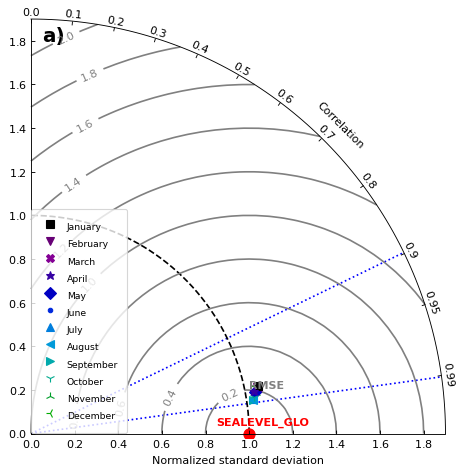

In [183]:
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(np.ma.std(A.ravel()), fig=figID_Taylor, rect=111, srange=(0., 1.9), label='Ocean Colour')
pp=[]
for i in range(11+1):
  ttt=TayDia.add_sample(STD_m[i], CORRCOEF[i], marker=MARCADORES[i%len(MARCADORES)], linestyle='None', color=COLORES(i), ms=8)#, ax=axs.ravel()[i])
  pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -0.26**2)],[0,0.26], color='blue',linestyle=':') # correlacion 0.99
plt.plot([0,NP.sqrt(1.9**2 -0.83**2)],[0,0.83], color='blue',linestyle=':') # correlacion 0.90
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, Meses,  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'SEALEVEL_GLO', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'a)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')

# California

## Datos Reanalisis

In [184]:
t_ini=np.datetime64('1993-01-01T12:00:00.000000000')
t_fin= np.datetime64('2017-12-31T12:00:00.000000000')
print(t_ini,t_fin)

1993-01-01T12:00:00.000000000 2017-12-31T12:00:00.000000000


In [185]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_PHY_SSH/California/Data_anual/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
R=xr.open_dataset('GLOBAL_REANALYSIS_PHY_SSH.nc')
R=R.where((R.time >=t_ini)&(R.time <= t_fin),drop=True)
R2= R.groupby('time.month').mean()
R2

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_PHY_SSH/California/Data_anual


<xarray.Dataset>
Dimensions:  (month: 12, lat: 121, lon: 81)
Coordinates:
  * lon      (lon) float32 230.0 230.2 230.5 230.8 ... 249.2 249.5 249.8 250.0
  * lat      (lat) float32 20.0 20.25 20.5 20.75 21.0 ... 49.25 49.5 49.75 50.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    SSH      (month, lat, lon) float32 0.3833 0.3805 0.3778 ... nan nan nan

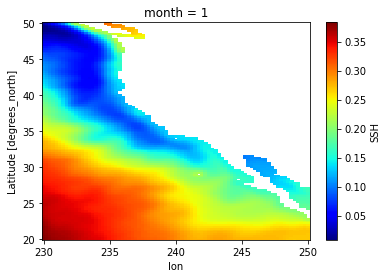

In [186]:
R2.sel(month=1).SSH.plot(cmap='jet')

## Datos Misiones satelitales

Datos de misiones satelitales DUACS: https://resources.marine.copernicus.eu/product-detail/SEALEVEL_GLO_PHY_L4_MY_008_047/INFORMATION

In [187]:
%ls '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/Datos_SSH_Satelite/'

GLOBAL_SSH_Benguela.nc    GLOBAL_SSH_Canarias.nc
GLOBAL_SSH_California.nc  GLOBAL_SSH_Humboldt.nc


In [188]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/Datos_SSH_Satelite/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
S=xr.open_dataset('GLOBAL_SSH_California.nc')
S 

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/Datos_SSH_Satelite


<xarray.Dataset>
Dimensions:         (month: 12, latitude: 60, longitude: 40, nv: 2)
Coordinates:
  * latitude        (latitude) float32 20.25 20.75 21.25 ... 48.75 49.25 49.75
  * longitude       (longitude) float32 -129.8 -129.2 -128.8 ... -110.8 -110.2
  * month           (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    SSH             (month, latitude, longitude) float32 ...
    SSHIBC          (month, latitude, longitude) float32 ...
    SSHNOIBC        (month, latitude, longitude) float32 ...
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...

## Interpolacion Reanalisis a Satelite

(60, 40)


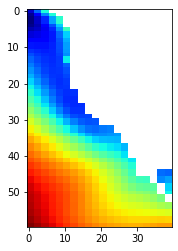

In [189]:
plt.imshow(np.flipud(S.SSH.sel(month=1).values),cmap='jet')
print(np.flipud(S.SSH.sel(month=1).values).shape)

(60, 40)


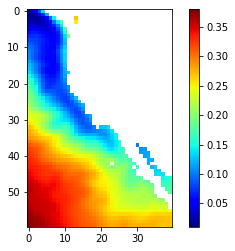

In [190]:
# Ejemplo para un mes
x= S.longitude.values
y= S.latitude.values
X_t, Y_t= np.meshgrid(x,y)
SSH_out=basemap.interp(datain=R2.sel(month=1).SSH.values, xin=R2.lon.values-360, yin=R2.lat.values, 
                            xout=X_t, yout=Y_t, order=1, masked= True)
print(SSH_out.shape)
plt.imshow(np.flipud(SSH_out),cmap='jet')
plt.colorbar()
plt.show()

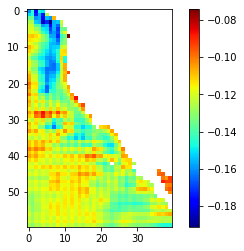

In [191]:
plt.imshow(np.flipud(SSH_out)-np.flipud(S.SSH.sel(month=1).values),cmap='jet')
plt.colorbar()

## Grafico de sesgo 

In [192]:
x1= S.longitude.values
y1=S.latitude.values;y1=y1[::-1];y1= np.array(y1);

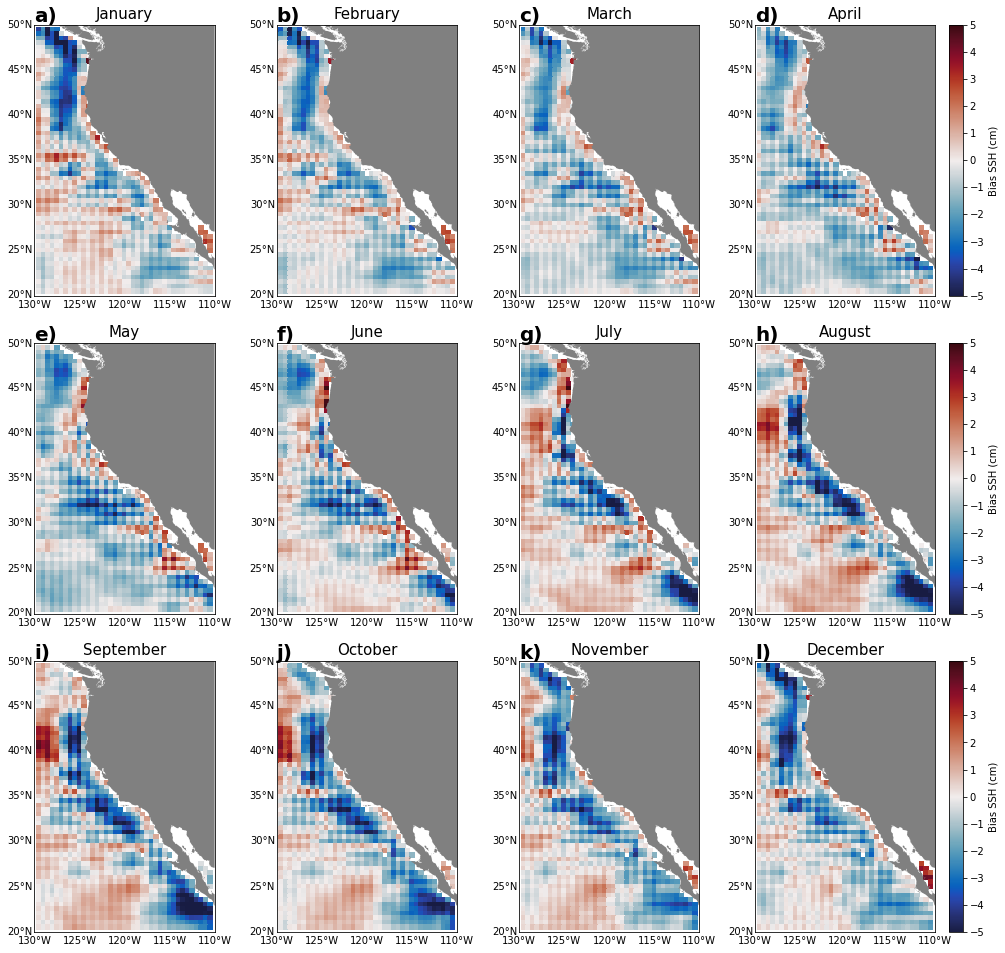

In [193]:
import string
ticks= np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5]) #labels para el colorbar
x1= S.longitude.values;y1=S.latitude.values;y1=y1[::-1];y1= np.array(y1);
w=0.23;h=0.17
meses=['January','February','March','April','May','June','July','August','September','October','November','December']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h],
        [0,0.70,w,h],[0.2,0.7,w,h],[0.4,0.7,w,h],[0.6,0.7,w,h],
        [0,0.5,w,h],[0.2,0.5,w,h],[0.4,0.5,w,h],[0.6,0.5,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(0.,1.01,string.ascii_lowercase[j]+')',fontsize=20, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=15)
  m=Basemap(projection='cyl',llcrnrlon=-130,llcrnrlat=20,urcrnrlon=-110,urcrnrlat=50, resolution ='h')
  x, y = m(x1, y1)
  # Interpolacion
  SSH_out=basemap.interp(datain=R2.sel(month=j+1).SSH.values, xin=R2.lon.values-360, yin=R2.lat.values, 
                            xout=X_t, yout=Y_t, order=1, masked= True)
  # Variable de interes sesgo
  z=(np.flipud(SSH_out)+0.12)-np.flipud(S.SSH.sel(month=j+1).values)
  cs=m.pcolormesh(x1, y1, z*100,cmap=cmocean.cm.balance,shading='flat',latlon=True,vmin=-5, vmax=5)
  m.drawcoastlines(color='white',zorder=0)
  m.fillcontinents(color='grey',lake_color='grey')
  m.drawparallels(np.arange(20,50+1,5.),labels=[1,0,0,0],linewidth=0.0)
  m.drawmeridians([-130,-125,-120,-115, -110],labels=[0,0,0,1],linewidth=0.0)
  if j in [3,7,11]:
    cbar=plt.colorbar(ticks=ticks)
    cbar.set_label('Bias SSH (cm)', rotation=90)

## Calculos previos de validacion

In [194]:
STD_m =[]
CORRCOEF = []
RMSE=[]
Meses=['January','February','March','April','May','June','July','August','September','October','November','December']
MARCADORES = ['s', 'v', 'X', '*', 'D','.','^','<','>','1','2','3','4','8','p','P','h','H','d']
COLORES = plt.cm.get_cmap('nipy_spectral', 24)
for k in range(1,12+1,1):
  # Extraccion de datos de modelo y satelite
  # Interpolacion
  modelo=np.flipud(basemap.interp(datain=R2.sel(month=k).SSH.values, xin=R2.lon.values-360, yin=R2.lat.values, 
                            xout=X_t, yout=Y_t, order=1, masked= True))
  #modelo= np.flipud(np.mean(np.log10(R2[k].chl.values[1:,:,:]), axis=0))# aplicar media en dimension tiempo
  #satelite= np.mean(S2[k].CHL.values[1:,:,:],axis=0) # aplicar media en dimension tiempo
  satelite= np.flipud(S.SSH.sel(month=k).values)
  # Sacar los indices que comparten en el espacio
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo))
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_m.append(np.ma.std(P.ravel()))
  CORRCOEF.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE.append(np.sqrt(np.mean((P-A)**2)))

In [195]:
dfr=pd.DataFrame({'STD':STD_m,'CORR':CORRCOEF,'RMSE':RMSE,'Mes':Meses})
dfr

,STD,CORR,RMSE,Mes
0,1.069219,0.990062,1.426309,January
1,1.039341,0.991274,1.428814,February
2,1.019724,0.992281,1.418501,March
3,1.011324,0.992367,1.434356,April
4,0.999322,0.989692,1.462867,May
5,1.035621,0.986659,1.464373,June
6,1.062870,0.983050,1.471471,July
7,1.082969,0.981047,1.477419,August
8,1.074123,0.980131,1.514853,September
9,1.071907,0.984752,1.484465,October


## Diagrama de Taylor

In [196]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


In [197]:
np.ma.std(A.ravel())

1.0

Text(1.0, 0.21, 'RMSE')

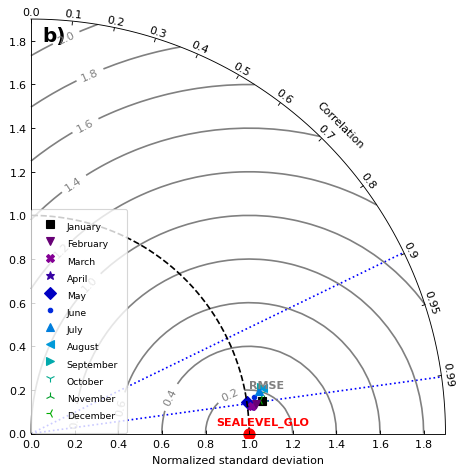

In [198]:
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(np.ma.std(A.ravel()), fig=figID_Taylor, rect=111, srange=(0., 1.9), label='Ocean Colour')
pp=[]
for i in range(11+1):
  ttt=TayDia.add_sample(STD_m[i], CORRCOEF[i], marker=MARCADORES[i%len(MARCADORES)], linestyle='None', color=COLORES(i), ms=8)#, ax=axs.ravel()[i])
  pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -0.26**2)],[0,0.26], color='blue',linestyle=':') # correlacion 0.99
plt.plot([0,NP.sqrt(1.9**2 -0.83**2)],[0,0.83], color='blue',linestyle=':') # correlacion 0.90
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, Meses,  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'SEALEVEL_GLO', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'b)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')

# Canarias

In [199]:
t_ini=np.datetime64('1993-01-01T12:00:00.000000000')
t_fin= np.datetime64('2017-12-31T12:00:00.000000000')
print(t_ini,t_fin)

1993-01-01T12:00:00.000000000 2017-12-31T12:00:00.000000000


In [200]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_PHY_SSH/Canarias/Data_anual/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
R=xr.open_dataset('GLOBAL_REANALYSIS_PHY_SSH.nc')
R=R.where((R.time >=t_ini)&(R.time <= t_fin),drop=True)
R2= R.groupby('time.month').mean()
R2

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_PHY_SSH/Canarias/Data_anual


<xarray.Dataset>
Dimensions:  (month: 12, lat: 121, lon: 81)
Coordinates:
  * lon      (lon) float32 335.0 335.2 335.5 335.8 ... 354.2 354.5 354.8 355.0
  * lat      (lat) float32 15.0 15.25 15.5 15.75 16.0 ... 44.25 44.5 44.75 45.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    SSH      (month, lat, lon) float32 -0.1288 -0.1281 ... -0.3717 -0.3711

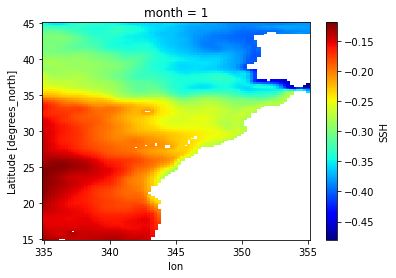

In [201]:
R2.sel(month=1).SSH.plot(cmap='jet')

## Datos Misiones satelitales

Datos de misiones satelitales DUACS: https://resources.marine.copernicus.eu/product-detail/SEALEVEL_GLO_PHY_L4_MY_008_047/INFORMATION

In [202]:
%ls '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/Datos_SSH_Satelite/'

GLOBAL_SSH_Benguela.nc    GLOBAL_SSH_Canarias.nc
GLOBAL_SSH_California.nc  GLOBAL_SSH_Humboldt.nc


In [203]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/Datos_SSH_Satelite/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
S=xr.open_dataset('GLOBAL_SSH_Canarias.nc')
S 

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/Datos_SSH_Satelite


<xarray.Dataset>
Dimensions:         (month: 12, latitude: 60, longitude: 40, nv: 2)
Coordinates:
  * latitude        (latitude) float32 15.25 15.75 16.25 ... 43.75 44.25 44.75
  * longitude       (longitude) float32 -24.75 -24.25 -23.75 ... -5.75 -5.25
  * month           (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    SSH             (month, latitude, longitude) float32 ...
    SSHIBC          (month, latitude, longitude) float32 ...
    SSHNOIBC        (month, latitude, longitude) float32 ...
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...

## Interpolacion Reanalisis a Satelite

(60, 40)


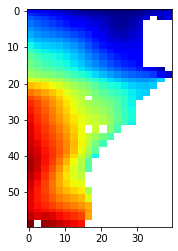

In [204]:
plt.imshow(np.flipud(S.SSH.sel(month=1).values),cmap='jet')
print(np.flipud(S.SSH.sel(month=1).values).shape)

(60, 40)


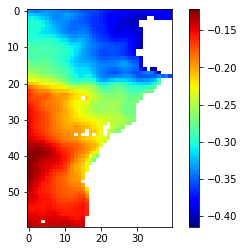

In [205]:
# Ejemplo para un mes
x= S.longitude.values
y= S.latitude.values
X_t, Y_t= np.meshgrid(x,y)
SSH_out=basemap.interp(datain=R2.sel(month=1).SSH.values, xin=R2.lon.values-360, yin=R2.lat.values, 
                            xout=X_t, yout=Y_t, order=1, masked= True)
print(SSH_out.shape)
plt.imshow(np.flipud(SSH_out),cmap='jet')
plt.colorbar()
plt.show()

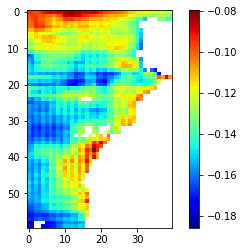

In [206]:
plt.imshow(np.flipud(SSH_out)-np.flipud(S.SSH.sel(month=1).values),cmap='jet')
plt.colorbar()

## Grafico de sesgo 

In [207]:
x1= S.longitude.values
y1=S.latitude.values;y1=y1[::-1];y1= np.array(y1);

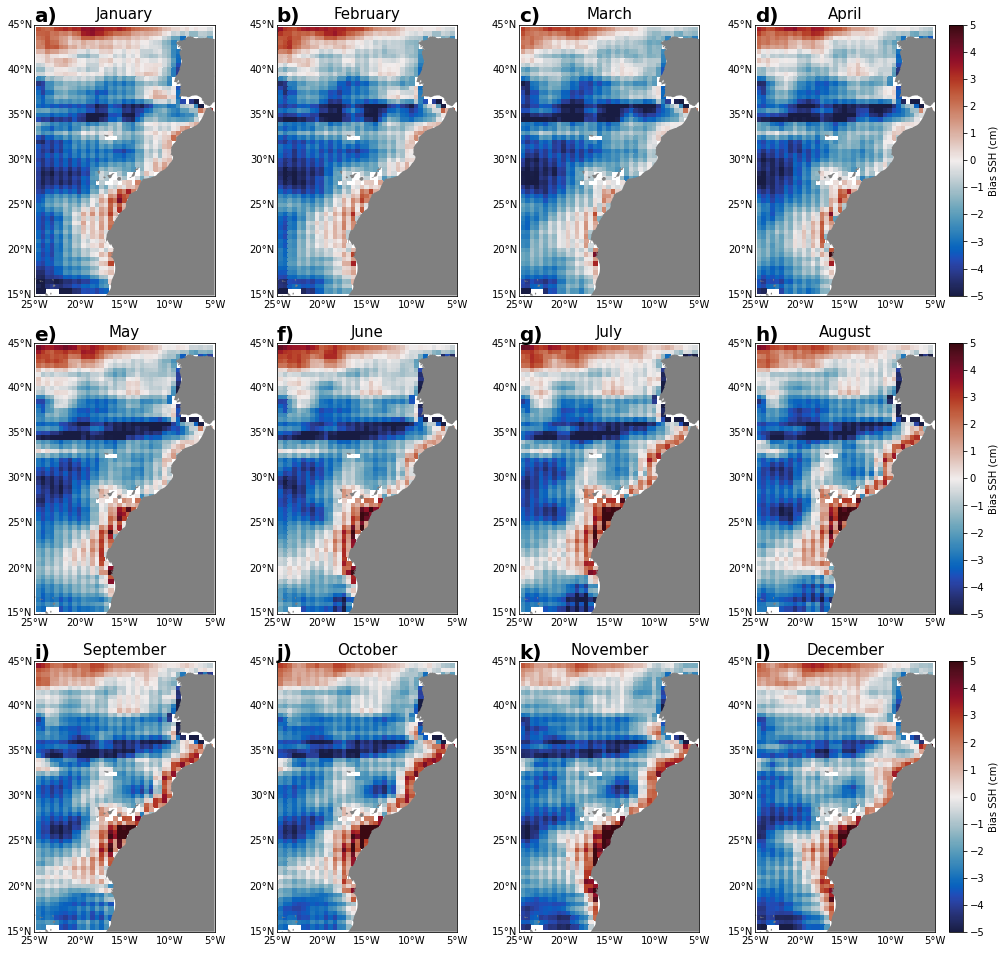

In [208]:
import string
ticks= np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5]) #labels para el colorbar
x1= S.longitude.values;y1=S.latitude.values;y1=y1[::-1];y1= np.array(y1);
w=0.23;h=0.17
meses=['January','February','March','April','May','June','July','August','September','October','November','December']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h],
        [0,0.70,w,h],[0.2,0.7,w,h],[0.4,0.7,w,h],[0.6,0.7,w,h],
        [0,0.5,w,h],[0.2,0.5,w,h],[0.4,0.5,w,h],[0.6,0.5,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(0.,1.01,string.ascii_lowercase[j]+')',fontsize=20, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=15)
  m=Basemap(projection='cyl',llcrnrlon=-25,llcrnrlat=15,urcrnrlon=-5,urcrnrlat=45, resolution ='h')
  x, y = m(x1, y1)
  # Interpolacion
  SSH_out=basemap.interp(datain=R2.sel(month=j+1).SSH.values, xin=R2.lon.values-360, yin=R2.lat.values, 
                            xout=X_t, yout=Y_t, order=1, masked= True)
  # Variable de interes sesgo
  z=(np.flipud(SSH_out)+0.12)-np.flipud(S.SSH.sel(month=j+1).values)
  cs=m.pcolormesh(x1, y1, z*100,cmap=cmocean.cm.balance,shading='flat',latlon=True,vmin=-5, vmax=5)
  m.drawcoastlines(color='white',zorder=0)
  m.fillcontinents(color='grey',lake_color='grey')
  m.drawparallels(np.arange(15,45+1,5.),labels=[1,0,0,0],linewidth=0.0)
  m.drawmeridians([-25,-20,-15,-10,-5],labels=[0,0,0,1],linewidth=0.0)
  if j in [3,7,11]:
    cbar=plt.colorbar(ticks=ticks)
    cbar.set_label('Bias SSH (cm)', rotation=90)

## Calculos previos de validacion

In [209]:
STD_m =[]
CORRCOEF = []
RMSE=[]
Meses=['January','February','March','April','May','June','July','August','September','October','November','December']
MARCADORES = ['s', 'v', 'X', '*', 'D','.','^','<','>','1','2','3','4','8','p','P','h','H','d']
COLORES = plt.cm.get_cmap('nipy_spectral', 24)
for k in range(1,12+1,1):
  # Extraccion de datos de modelo y satelite
  # Interpolacion
  modelo=np.flipud(basemap.interp(datain=R2.sel(month=k).SSH.values, xin=R2.lon.values-360, yin=R2.lat.values, 
                            xout=X_t, yout=Y_t, order=1, masked= True))
  #modelo= np.flipud(np.mean(np.log10(R2[k].chl.values[1:,:,:]), axis=0))# aplicar media en dimension tiempo
  #satelite= np.mean(S2[k].CHL.values[1:,:,:],axis=0) # aplicar media en dimension tiempo
  satelite= np.flipud(S.SSH.sel(month=k).values)
  # Sacar los indices que comparten en el espacio
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo))
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_m.append(np.ma.std(P.ravel()))
  CORRCOEF.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE.append(np.sqrt(np.mean((P-A)**2)))

In [210]:
dfr=pd.DataFrame({'STD':STD_m,'CORR':CORRCOEF,'RMSE':RMSE,'Mes':Meses})
dfr

,STD,CORR,RMSE,Mes
0,0.892019,0.981269,1.491892,January
1,0.917198,0.978752,1.550851,February
2,0.939242,0.980872,1.573867,March
3,0.927012,0.980104,1.541010,April
4,0.938041,0.976071,1.537502,May
5,0.943450,0.972560,1.556533,June
6,0.924204,0.968628,1.566074,July
7,0.930559,0.969811,1.581655,August
8,0.938382,0.973487,1.533183,September
9,0.949451,0.975686,1.466548,October


## Diagrama de Taylor

In [211]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


Text(1.0, 0.21, 'RMSE')

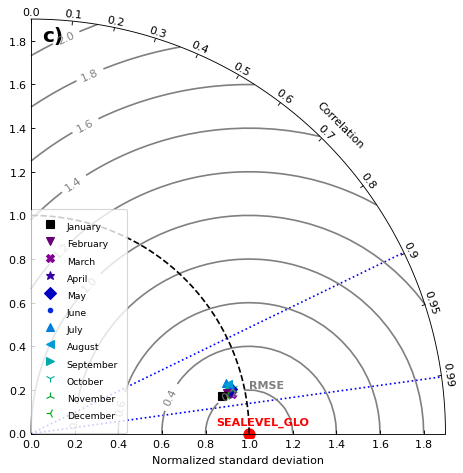

In [212]:
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(np.ma.std(A.ravel()), fig=figID_Taylor, rect=111, srange=(0., 1.9), label='Ocean Colour')
pp=[]
for i in range(11+1):
  ttt=TayDia.add_sample(STD_m[i], CORRCOEF[i], marker=MARCADORES[i%len(MARCADORES)], linestyle='None', color=COLORES(i), ms=8)#, ax=axs.ravel()[i])
  pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -0.26**2)],[0,0.26], color='blue',linestyle=':') # correlacion 0.99
plt.plot([0,NP.sqrt(1.9**2 -0.83**2)],[0,0.83], color='blue',linestyle=':') # correlacion 0.90
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, Meses,  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'SEALEVEL_GLO', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'c)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')

# Benguela

In [213]:
t_ini=np.datetime64('1993-01-01T12:00:00.000000000')
t_fin= np.datetime64('2017-12-31T12:00:00.000000000')
print(t_ini,t_fin)

1993-01-01T12:00:00.000000000 2017-12-31T12:00:00.000000000


In [214]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_PHY_SSH/Benguela/Data_anual/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
R=xr.open_dataset('GLOBAL_REANALYSIS_PHY_SSH.nc')
R=R.where((R.time >=t_ini)&(R.time <= t_fin),drop=True)
R2= R.groupby('time.month').mean()
R2

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_PHY_SSH/Benguela/Data_anual


<xarray.Dataset>
Dimensions:  (month: 12, lat: 121, lon: 81)
Coordinates:
  * lon      (lon) float32 5.0 5.25 5.5 5.75 6.0 ... 24.0 24.25 24.5 24.75 25.0
  * lat      (lat) float32 -40.0 -39.75 -39.5 -39.25 ... -10.5 -10.25 -10.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    SSH      (month, lat, lon) float32 -0.1226 -0.1238 -0.1232 ... nan nan nan

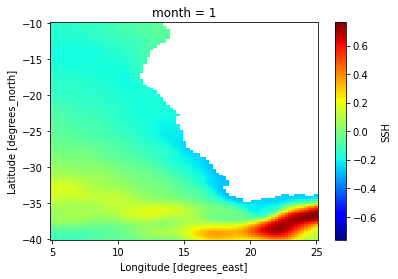

In [215]:
R2.sel(month=1).SSH.plot(cmap='jet')

## Datos Misiones satelitales

Datos de misiones satelitales DUACS: https://resources.marine.copernicus.eu/product-detail/SEALEVEL_GLO_PHY_L4_MY_008_047/INFORMATION

In [216]:
%ls '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/Datos_SSH_Satelite/'

GLOBAL_SSH_Benguela.nc    GLOBAL_SSH_Canarias.nc
GLOBAL_SSH_California.nc  GLOBAL_SSH_Humboldt.nc


In [217]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/Datos_SSH_Satelite/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
S=xr.open_dataset('GLOBAL_SSH_Benguela.nc')
S 

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/Datos_SSH_Satelite


<xarray.Dataset>
Dimensions:         (month: 12, latitude: 60, longitude: 40, nv: 2)
Coordinates:
  * latitude        (latitude) float32 -39.75 -39.25 -38.75 ... -10.75 -10.25
  * longitude       (longitude) float32 5.25 5.75 6.25 ... 23.75 24.25 24.75
  * month           (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    SSH             (month, latitude, longitude) float32 ...
    SSHIBC          (month, latitude, longitude) float32 ...
    SSHNOIBC        (month, latitude, longitude) float32 ...
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...

## Interpolacion Reanalisis a Satelite

(60, 40)


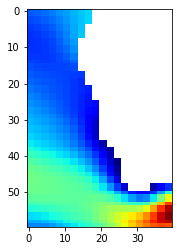

In [218]:
plt.imshow(np.flipud(S.SSH.sel(month=1).values),cmap='jet')
print(np.flipud(S.SSH.sel(month=1).values).shape)

(60, 40)


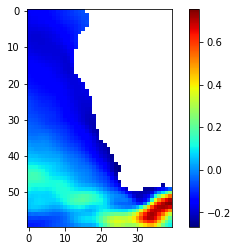

In [219]:
# Ejemplo para un mes
x= S.longitude.values
y= S.latitude.values
X_t, Y_t= np.meshgrid(x,y)
SSH_out=basemap.interp(datain=R2.sel(month=1).SSH.values, xin=R2.lon.values, yin=R2.lat.values, 
                            xout=X_t, yout=Y_t, order=1, masked= True)
print(SSH_out.shape)
plt.imshow(np.flipud(SSH_out),cmap='jet')
plt.colorbar()
plt.show()

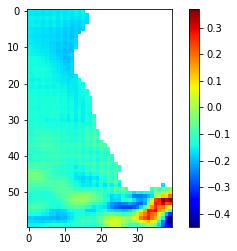

In [220]:
plt.imshow(np.flipud(SSH_out)-np.flipud(S.SSH.sel(month=1).values),cmap='jet')
plt.colorbar()

## Grafico de sesgo 

In [221]:
x1= S.longitude.values
y1=S.latitude.values;y1=y1[::-1];y1= np.array(y1);

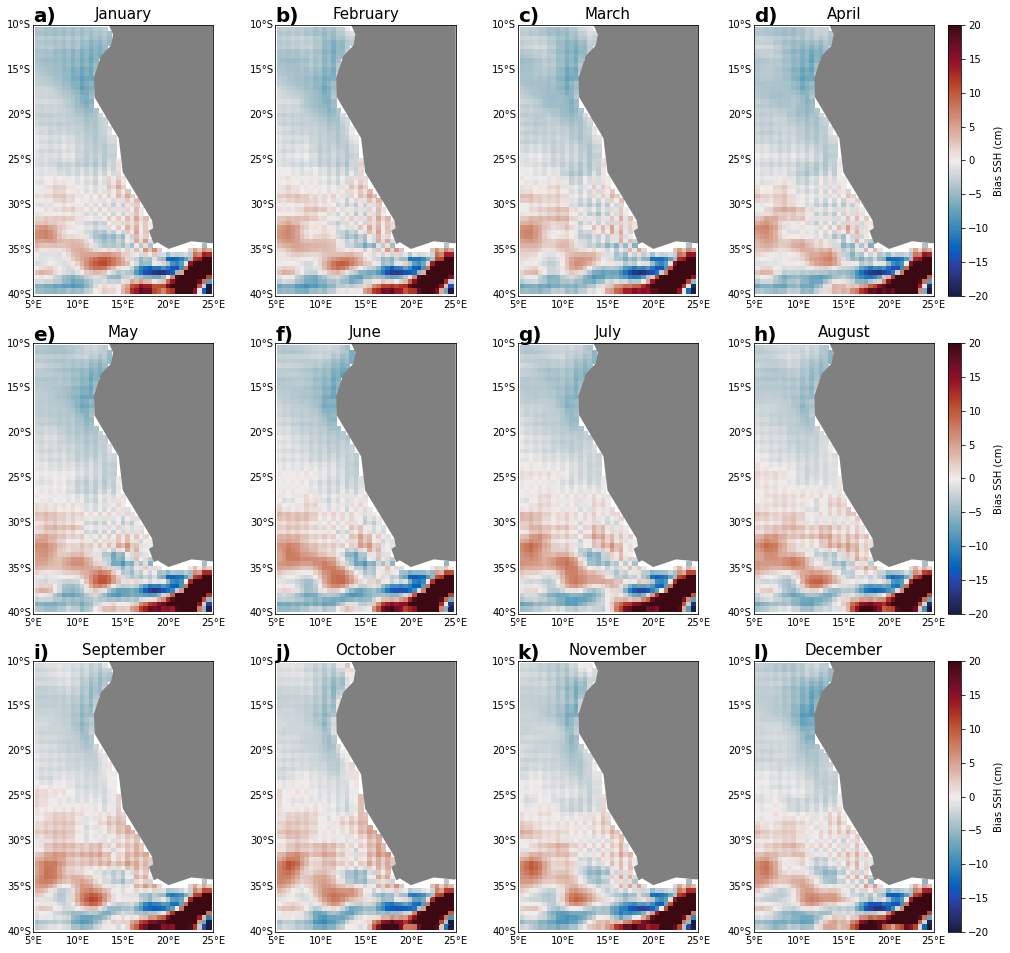

In [222]:
import string
ticks= np.array([-20,-15,-10,-5,0,5,10,15,20]) #labels para el colorbar
x1= S.longitude.values;y1=S.latitude.values;y1=y1[::-1];y1= np.array(y1);
w=0.23;h=0.17
meses=['January','February','March','April','May','June','July','August','September','October','November','December']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h],
        [0,0.70,w,h],[0.2,0.7,w,h],[0.4,0.7,w,h],[0.6,0.7,w,h],
        [0,0.5,w,h],[0.2,0.5,w,h],[0.4,0.5,w,h],[0.6,0.5,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(0.,1.01,string.ascii_lowercase[j]+')',fontsize=20, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=15)
  m=Basemap(projection='cyl',llcrnrlon=5,llcrnrlat=-40,urcrnrlon=25,urcrnrlat=-10, resolution ='c')
  x, y = m(x1, y1)
  # Interpolacion
  SSH_out=basemap.interp(datain=R2.sel(month=j+1).SSH.values, xin=R2.lon.values, yin=R2.lat.values, 
                            xout=X_t, yout=Y_t, order=1, masked= True)
  # Variable de interes sesgo
  z=(np.flipud(SSH_out)+0.12)-np.flipud(S.SSH.sel(month=j+1).values)
  cs=m.pcolormesh(x1, y1, z*100,cmap=cmocean.cm.balance,shading='flat',latlon=True,vmin=-20, vmax=20)
  m.drawcoastlines(color='white',zorder=0)
  m.fillcontinents(color='grey',lake_color='grey')
  m.drawparallels(np.arange(-40,-10+1,5.),labels=[1,0,0,0],linewidth=0.0)
  m.drawmeridians([5,10,15,20,25],labels=[0,0,0,1],linewidth=0.0)
  if j in [3,7,11]:
    cbar=plt.colorbar(ticks=ticks)
    cbar.set_label('Bias SSH (cm)', rotation=90)

## Calculos previos de validacion

In [223]:
STD_m =[]
CORRCOEF = []
RMSE=[]
Meses=['January','February','March','April','May','June','July','August','September','October','November','December']
MARCADORES = ['s', 'v', 'X', '*', 'D','.','^','<','>','1','2','3','4','8','p','P','h','H','d']
COLORES = plt.cm.get_cmap('nipy_spectral', 24)
for k in range(1,12+1,1):
  # Extraccion de datos de modelo y satelite
  # Interpolacion
  modelo=np.flipud(basemap.interp(datain=R2.sel(month=k).SSH.values, xin=R2.lon.values, yin=R2.lat.values, 
                            xout=X_t, yout=Y_t, order=1, masked= True))
  #modelo= np.flipud(np.mean(np.log10(R2[k].chl.values[1:,:,:]), axis=0))# aplicar media en dimension tiempo
  #satelite= np.mean(S2[k].CHL.values[1:,:,:],axis=0) # aplicar media en dimension tiempo
  satelite= np.flipud(S.SSH.sel(month=k).values)
  # Sacar los indices que comparten en el espacio
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo))
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_m.append(np.ma.std(P.ravel()))
  CORRCOEF.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE.append(np.sqrt(np.mean((P-A)**2)))

In [224]:
dfr=pd.DataFrame({'STD':STD_m,'CORR':CORRCOEF,'RMSE':RMSE,'Mes':Meses})
dfr

,STD,CORR,RMSE,Mes
0,1.340151,0.925041,1.060760,January
1,1.353370,0.926241,1.045660,February
2,1.371445,0.915275,1.075619,March
3,1.366948,0.921243,1.078359,April
4,1.373136,0.927578,1.083282,May
5,1.406892,0.924947,1.112456,June
6,1.403491,0.923670,1.092021,July
7,1.389144,0.922847,1.088689,August
8,1.363513,0.917570,1.080487,September
9,1.361893,0.914074,1.076409,October


## Diagrama de Taylor

In [225]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


Text(1.0, 0.21, 'RMSE')

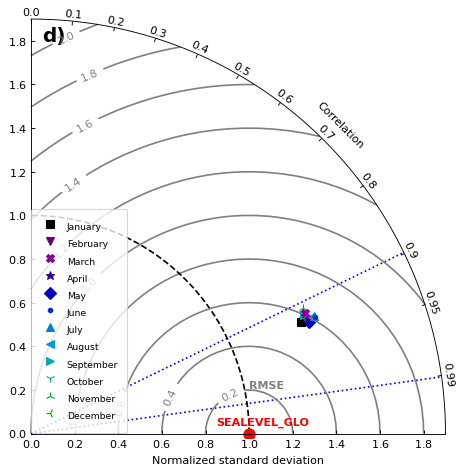

In [226]:
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(np.ma.std(A.ravel()), fig=figID_Taylor, rect=111, srange=(0., 1.9), label='Ocean Colour')
pp=[]
for i in range(11+1):
  ttt=TayDia.add_sample(STD_m[i], CORRCOEF[i], marker=MARCADORES[i%len(MARCADORES)], linestyle='None', color=COLORES(i), ms=8)#, ax=axs.ravel()[i])
  pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -0.26**2)],[0,0.26], color='blue',linestyle=':') # correlacion 0.99
plt.plot([0,NP.sqrt(1.9**2 -0.83**2)],[0,0.83], color='blue',linestyle=':') # correlacion 0.90
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, Meses,  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'SEALEVEL_GLO', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'d)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')